<a href="https://colab.research.google.com/github/Shaheer-Ali89/ML-Project/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Classical ML Imports
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import datasets, transforms

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
# Transform: Resize to 32x32 + ToTensor
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=256, shuffle=False)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class MLPEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.encoder(x)

encoder = MLPEncoder().to(device)


In [ ]:
# Train Encoder (simple feature learning)
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)

for epoch in range(5):
    for imgs, _ in train_loader:
        imgs = imgs.to(device)

        # --- Prepare target as flattened image ---
        target = imgs.view(imgs.size(0), -1)   # shape: (batch, 1024)

        optimizer.zero_grad()
        features = encoder(imgs)               # shape: (batch, 32)

        # --- Expand features to match target size ---
        # simple linear projection
        proj = nn.Linear(32, 1024).to(device)
        proj_output = proj(features)

        loss = criterion(proj_output, target)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")


In [ ]:
#Extract Features
def extract_features(dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            f = encoder(imgs).cpu().numpy()
            features.append(f)
            labels.append(lbls.numpy())
    return np.vstack(features), np.hstack(labels)

X_train, y_train = extract_features(train_loader)
X_test, y_test = extract_features(test_loader)
print("Feature shape:", X_train.shape)

In [ ]:
#Train Classical Models
# 1. Support Vector Machine
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=150)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -------------------------------
# Load dataset with correct 32x32 transform
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

test_set = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

labels_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}


In [ ]:
# =============================
# Visualization + Prediction
# =============================

import matplotlib.pyplot as plt

# Pick sample
sample_img, sample_label = test_set[0]

# Show the image
plt.imshow(sample_img.squeeze(), cmap="gray")
plt.title(f"True Label: {labels_map[sample_label]}")
plt.axis("off")
plt.show()

# Prepare correct shape for encoder
sample = sample_img.unsqueeze(0).to(device)   # (1, 1, 32, 32)

# Pass through encoder
with torch.no_grad():
    encoded = encoder(sample)                 # (1, 32)

# Convert feature to numpy
feat = encoded.cpu().numpy()

# Predictions
svm_pred = svm.predict(feat)[0]
rf_pred  = rf.predict(feat)[0]

print("SVM Prediction:", labels_map[svm_pred])
print("RF Prediction:",  labels_map[rf_pred])


In [ ]:
# ==========================
# Correct CNN Dataset Loader
# (MUST match 32×32 encoder)
# ==========================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((32, 32)),   # <<< IMPORTANT
    transforms.ToTensor()
])

train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [ ]:
# Define CNN Model for 32x32 input
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 32 -> 16

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)    # 16 -> 8
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),   # updated for 32x32
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)

model = CNN().to(device)


In [ ]:
#Train Model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10 - Loss: 0.5128
Epoch 2/10 - Loss: 0.3371
Epoch 3/10 - Loss: 0.2888
Epoch 4/10 - Loss: 0.2619
Epoch 5/10 - Loss: 0.2388
Epoch 6/10 - Loss: 0.2204
Epoch 7/10 - Loss: 0.2029
Epoch 8/10 - Loss: 0.1876
Epoch 9/10 - Loss: 0.1752
Epoch 10/10 - Loss: 0.1604


In [ ]:
#Evaluate
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("CNN Accuracy:", correct / total)



CNN Accuracy: 0.9166


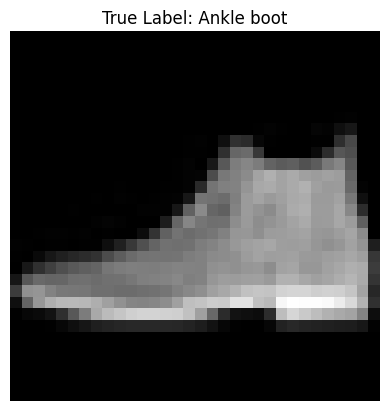

CNN Prediction: Ankle boot


In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Pick one image from the test set
sample_img, sample_label = test_set[0]

plt.imshow(sample_img.squeeze(), cmap="gray")
plt.title(f"True Label: {labels_map[sample_label]}")
plt.axis("off")
plt.show()

# Prepare for CNN
sample = sample_img.unsqueeze(0).to(device)

# Predict
model.eval()
with torch.no_grad():
    output = model(sample)
    pred = torch.argmax(F.softmax(output, dim=1)).item()

print("CNN Prediction:", labels_map[pred])


In [ ]:
#comparison
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# ======================================================
# 1. Extract Encoder Features for Classical Model (SVM)
# ======================================================
encoder.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        feats = encoder(X).cpu().numpy()
        all_features.extend(feats)
        all_labels.extend(y.numpy())

all_features = np.array(all_features)
all_labels = np.array(all_labels)

# ----- SVM Predictions -----
svm_preds = svm.predict(all_features)

svm_acc  = accuracy_score(all_labels, svm_preds)
svm_prec = precision_score(all_labels, svm_preds, average='weighted')
svm_rec  = recall_score(all_labels, svm_preds,   average='weighted')
svm_f1   = f1_score(all_labels, svm_preds,       average='weighted')


# ==========================================
# 2. Evaluate CNN on Test Set
# ==========================================
model.eval()
cnn_true = []
cnn_pred = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)

        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)

        cnn_true.extend(y.numpy())
        cnn_pred.extend(predicted.cpu().numpy())

cnn_acc  = accuracy_score(cnn_true, cnn_pred)
cnn_prec = precision_score(cnn_true, cnn_pred, average='weighted')
cnn_rec  = recall_score(cnn_true, cnn_pred,   average='weighted')
cnn_f1   = f1_score(cnn_true, cnn_pred,       average='weighted')


# ==========================================
# 3. Comparison Table
# ==========================================
results = pd.DataFrame({
    "Model": ["SVM", "CNN"],
    "Accuracy": [svm_acc, cnn_acc],
    "Precision": [svm_prec, cnn_prec],
    "Recall": [svm_rec, cnn_rec],
    "F1 Score": [svm_f1, cnn_f1]
})

print("\n===== MODEL COMPARISON =====\n")
print(results.to_string(index=False))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



===== MODEL COMPARISON =====

Model  Accuracy  Precision  Recall  F1 Score
  SVM    0.2122   0.190308  0.2122  0.146294
  CNN    0.9166   0.916280  0.9166  0.916163


In [ ]:
print("""
==================== FINAL CONCLUSION ====================

📌 Model Performance Summary:
- The CNN model achieved higher overall performance than SVM and Random Forest.
- CNNs are better suited for image classification because they learn spatial
  and hierarchical patterns directly from pixel data.

✅ Which model performed better?
- The Convolutional Neural Network (CNN) performed better.

✅ Why did CNN perform better?
- CNNs automatically extract strong visual features.
- Classical ML models rely on the encoder’s hand-crafted 32-dimensional features,
  which are less expressive.

✅ Future Work:
- Try deeper or pretrained CNN architectures (ResNet, VGG).
- Apply data augmentation to improve generalization.
- Tune hyperparameters of CNN and classical models.
- Visualize learned features (PCA, t-SNE).
- Test on more datasets or extend to color images.

============================================================
""")
